# MUSIC algorithm for DOA

**mini-project for COM-500 (Statistical Signal Processing through Applications) at EPFL**

**Authors:**

* *Huang Guyue*
* *Iriarte Sainz Diego Gabriel*
* *Nyambuu Lkham*

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import json
import math

---
## Part 2. MUSIC implementation on real data

### Experiment description
The experiment details are described at https://github.com/fakufaku/pyramic-dataset/blob/master/PROTOCOL.md.
The geometry of the experiment is described in the machine readable file https://github.com/fakufaku/pyramic-dataset/blob/master/protocol.json. Below is an example how to get the indexes of the top layer of microphone for 2D experiments.

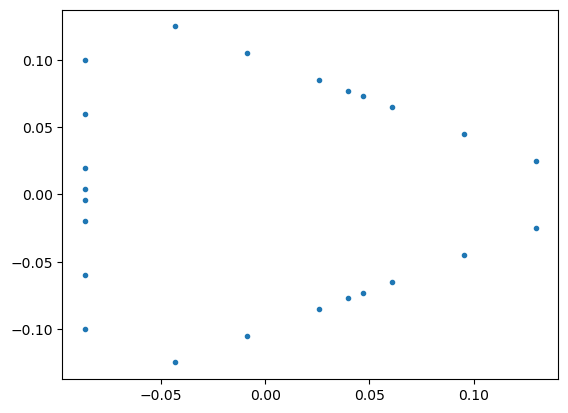

In [16]:
with open('protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

plt.plot(microphone_2D_locations[:,0],microphone_2D_locations[:,1],'.')
plt.show()

arrayid = np.arange(48)[top_mics]
side1 = arrayid[:8]

In [17]:
def music(X, f, P, M, locations):
    wavelen = 343 / f
    locations = locations - locations[0,:]
    
    Xmean = np.mean(X, axis=1)
    X0 = X - np.tile(Xmean, (np.shape(X)[1],1)).T
    R = np.dot(X0, X0.conj().T)
    if M==8:
        J = np.flip(np.eye(M), axis=1)
        R = R + np.dot(J, np.dot(R.conj(), J))
    w, v = np.linalg.eig(R)
    ids = np.abs(w).argsort()[:(M-P)] # find the smallest eignvalues
    En = v[:,ids]
    Ren = np.dot(En, En.conj().T)
    
    if M==8:
        theta = np.arange(-90, 90, 1)
        d = np.array([0, 0.04, 0.08, 0.098, 0.102, 0.12, 0.16, 0.2])
        atheta = np.exp(-1j*2*np.pi/wavelen*np.kron(d, np.sin(theta/180*np.pi)).reshape(8, np.size(theta)))
    else:
        theta = np.arange(0, 360, 1)
        a = np.array([np.cos(theta/180*np.pi), np.sin(theta/180*np.pi)])
        atheta = np.exp(-1j*2*np.pi/wavelen*np.dot(locations, a))

    l = np.size(theta)
    Pmusic = np.zeros(l)
    for j in range(l):
        Pmusic[j] = 1/abs(np.dot(np.dot(atheta[:,j].conj().T, Ren), atheta[:,j]))

    return Pmusic, theta

---
### 2.1 Single-source line-array
For a real-data, our general steps is to
* choose a proper period of audio data, because sometimes it would be just noice and the frequency is quite dirty.
* take a look at the frequency composition, choose a main frequency to caculate wavelength. In matlab we can perform some band-filter on the data, which would improve the performance of algorithm
* apply MUSIC

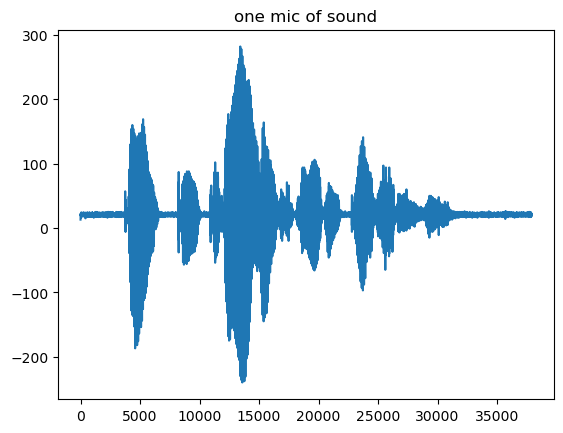

In [18]:
# to take a look, find a proper interval
rate, data = wavfile.read('fq_sample3_spkr0_angle20.wav');
plt.plot(data[:,0])
plt.title("one mic of sound")
plt.show()

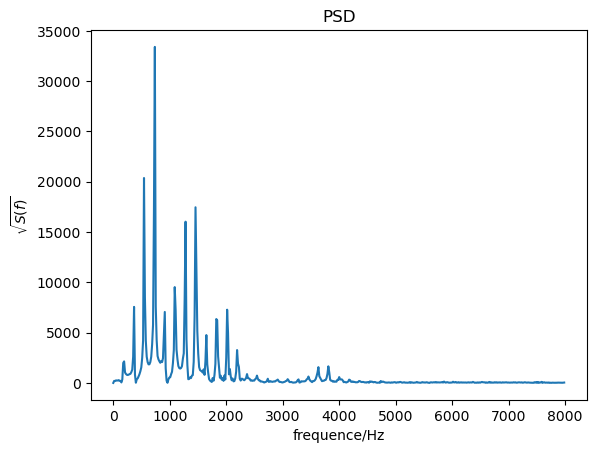

In [19]:
# take a look at the frequency composition
intv = np.arange(13000, 14000)
fs = 16000
Xw = np.fft.fft(data[intv, 0] - np.mean(data[intv,0]))
L = np.size(Xw)/2
plt.plot(np.arange(0, fs/2, fs/2/L), np.abs(Xw[:int(L)]))
plt.xlabel('frequence/Hz')
plt.ylabel('$\sqrt{S(f)}$')
plt.title('PSD')
plt.show()

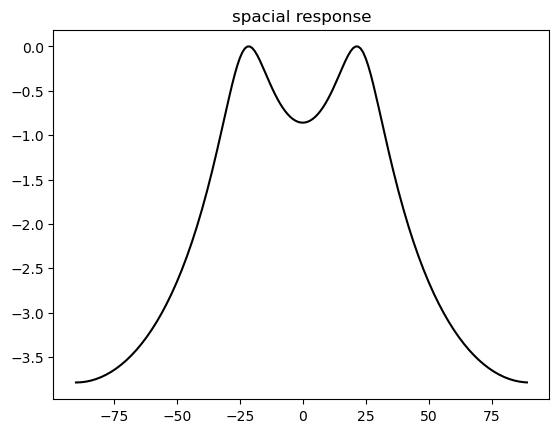

The coming direction is : -21


In [21]:
f = 750
dataslice = data[intv, :]
array = np.arange(48)[top_mics]
side1 = array[:8]
X = dataslice[:,side1].T

# use MUSIC ~~
Pmusic, theta = music(X, f, P=2, M=8, locations=microphone_2D_locations)

Pmusic = np.log(Pmusic / np.max(Pmusic))
plt.plot(theta, Pmusic, '-k')
plt.title('spacial response')
plt.show()

direction = theta[np.argmax(Pmusic)]
print("The coming direction is : %d" % direction)

---
### 2.2 Two-source sweep (co & uncorrelated)  line-array
We go to multi-source real data.

In [22]:
true_angle = {"speechco":[42, 350, 222, 170], 
              "speechun":[8, 60, 188, 240], 
              "sweepco": [32, 66, 212, 246],
              "sweepun": [120, 150, 300, 330]}
true_angle_for_side = {0: {"speechco":[42, 10, -42, -10], 
                           "speechun":[8, 60, -8, -60], 
                           "sweepco": [32, 66, -32, -66],
                           "sweepun": [60, 30, -60, -30]},
                       1: {"speechco":[78, -78, 50, -50], 
                           "speechun":[68, -68, 30, -30], 
                           "sweepco": [88, -88, 24, -24],
                           "sweepun": [0, 30, -30]},
                       2: {"speechco":[18, -18, -70, 70], 
                           "speechun":[52, -52, 0], 
                           "sweepco": [28, -28, 6, -6],
                           "sweepun": [60, -60, 90, -90]}}

You can change the following filepath to see different files.

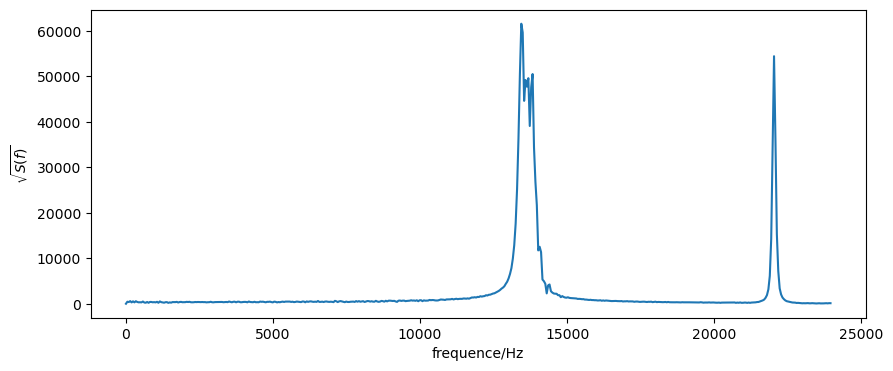

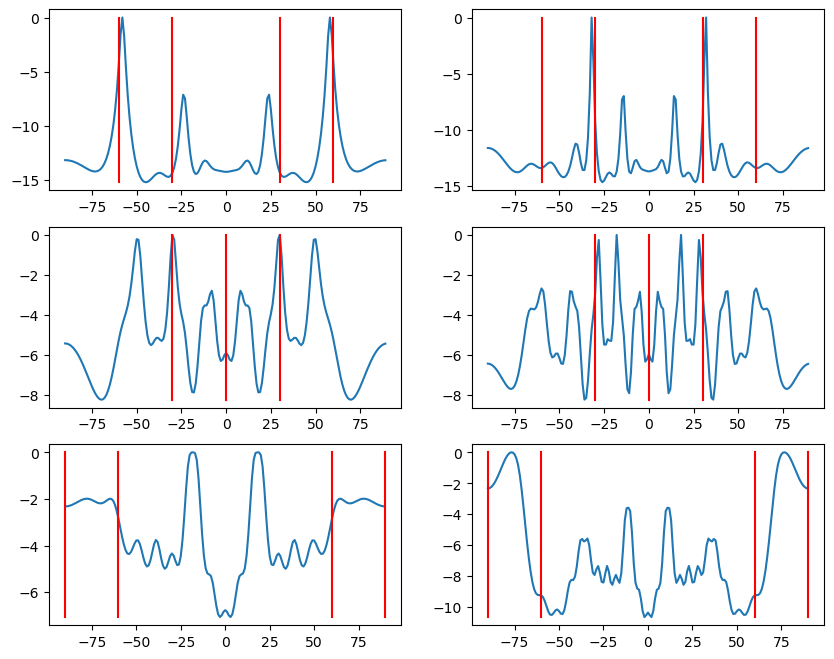

In [23]:
# three-sides detection
rate, data = wavfile.read('sweep_uncorrelated.wav')
intv = np.arange(11000, 12000)
dataslice = data[intv, :]
N = np.size(intv)
L = N/2
plt.figure(figsize=(10,4))

fs = rate
Xw = np.fft.fft(data[intv, 0] - np.mean(data[intv, 0]))
plt.plot(np.arange(0, fs/2, fs/2/L), np.abs(Xw[:int(L)]))
plt.xlabel('frequence/Hz')
plt.ylabel('$\sqrt{S(f)}$')
plt.show()


f1 = 13680
f2 = 22032
arg1 = np.array([math.floor(f1/fs*1000), math.floor((fs-f1)/fs*1000)])
arg2 = np.array([math.floor(f2/fs*1000), math.floor((fs-f2)/fs*1000)])
s1 = np.zeros((N, 24), dtype=complex)
s2 = s1
for j in range(24):
    S = np.fft.fft(dataslice[:, j])
    S1 = np.zeros(N, dtype=complex)
    S1[arg1] = S[arg1]
    S2 = np.zeros(N, dtype=complex)
    S2[arg2] = S[arg2]
    s1[:, j] = np.fft.ifft(S1)
    s2[:, j] = np.fft.ifft(S2)

plt.figure(figsize=(10,8))
for i in range(3):
    X1 = s1[:, 8*i:8*(i+1)].T
    X2 = s2[:, 8*i:8*(i+1)].T
    Pmusic, theta = music(X1, f1, 2, 8, microphone_2D_locations)
    Pmusic = 10*np.log10(Pmusic / np.max(Pmusic))
    plt.subplot(3, 2,2*i+1)
    plt.plot(theta, Pmusic)
    for angle in true_angle_for_side[i]["sweepun"]:
        plt.plot([angle, angle],[Pmusic.min(), Pmusic.max()], 'r')
    Pmusic, theta = music(X2, f2, 2, 8, microphone_2D_locations)
    Pmusic = 10*np.log10(Pmusic / np.max(Pmusic))
    plt.subplot(3, 2,2*i+2)
    plt.plot(theta, Pmusic)
    for angle in true_angle_for_side[i]["sweepun"]:
        plt.plot([angle, angle],[Pmusic.min(), Pmusic.max()], 'r')
        
plt.show()

### 2.3 Single source  triangle-array

Based on 2-D coordinates of the data, we can calculate the phase difference between any two points along a certain angle. If a node has coordinates $(x, y)$, and a signal comes from angle $\theta$ counter-clockwise to x-axis, then the phase delay of it from zero point should be 

$$
\Delta\phi = 2\pi\frac{d}{\lambda}
= 2\pi\frac{x\cos(\theta) + y\sin(\theta)}{\lambda}
$$

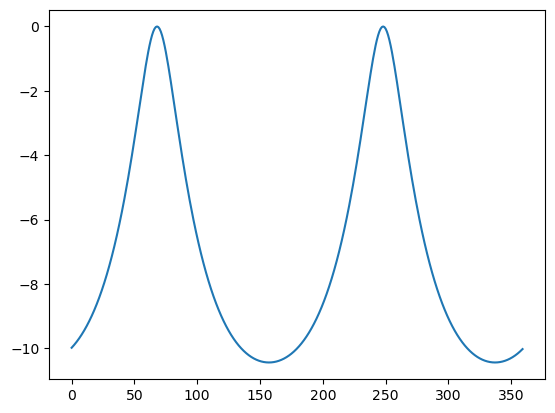

The coming direction is: 68


In [24]:
# again on single source to verify
rate, data = wavfile.read('fq_sample3_spkr0_angle70.wav');
intv = np.arange(12000, 13000)
dataslice = data[intv, :]
f = 900

X = dataslice[:, top_mics].T
Pmusic, theta = music(X, f, 2, 24, microphone_2D_locations)
Pmusic = 10*np.log10(Pmusic / np.max(Pmusic))

plt.plot(theta, Pmusic)
plt.show()

print("The coming direction is: %d"% theta[np.argsort(Pmusic[:180])[-1]])

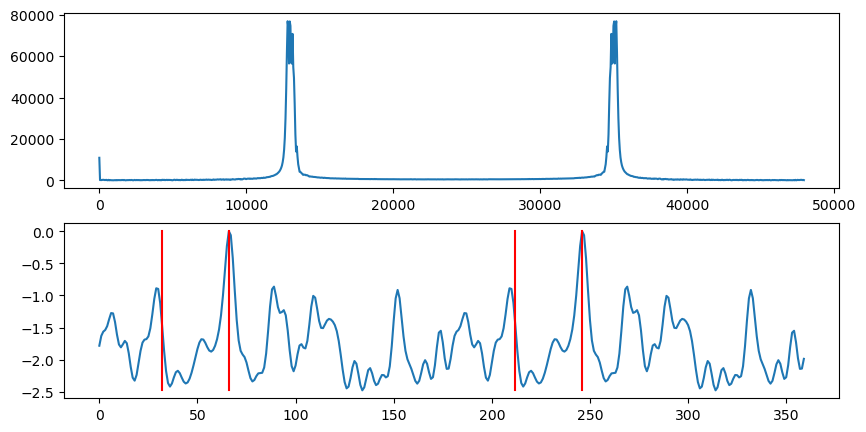

In [10]:
# triangle-detection
rate, data = wavfile.read('sweep_correlated.wav')
intv = np.arange(12000, 13000)
dataslice = data[intv, :]
f = 12816
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(np.arange(0, rate, rate/1000), np.abs(np.fft.fft(dataslice[:,0])))

X = dataslice.T
Pmusic, theta = music(X, f, 4, 24, microphone_2D_locations)

Pmusic = 10*np.log10(Pmusic / np.max(Pmusic))
plt.subplot(2,1,2)
plt.plot(theta, Pmusic)
for angle in true_angle["sweepco"]:
    plt.plot([angle, angle],[Pmusic.min(), 0], 'r')
plt.show()

---
## Part 3. MUSIC implementation with pyroomacoustics Library
Pyroomacoustics is a software package aimed at the rapid development and testing of audio array processing algorithms.
To be able to run this notebook, pyroomacoustics must be installed:

'pip install pyroomacoustics'

In [11]:
!pip install pyroomacoustics

In [12]:
import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

#### Collecting Microphones indices

In [13]:
indices=np.arange(len(top_mics))[top_mics]
print(indices)

[ 8  9 10 11 12 13 14 15 24 25 26 27 28 29 30 31 40 41 42 43 44 45 46 47]


#### DOA for two sources
In this part we simulate the DOA for two sources with known angles. We add them together and perform the algorithm

In [14]:
## Input signal with known angles
rate1, data1 = wavfile.read('fq_sample3_spkr0_angle20.wav')
rate2, data2=wavfile.read('fq_sample3_spkr0_angle70.wav')
final_data=data1[:,indices]+data2[:,indices]
'''
DOA Algorithms
==============
'''
########################
# Define some parameters
c = 343.    # speed of sound
fs = rate1  # sampling frequency
nfft = 256  # FFT size
#freq_bins=np.arange(-90,90,0.5)
freq_bins=np.arange(30, 180)

number_source=2
R=microphone_2D_locations.T

################################
# Compute the STFT frames needed
X = np.array([ 
    pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T 
    for signal in final_data.T])

##############################################
# Now we can test all the algorithms available
algo_name = 'MUSIC'

doa = pra.doa.algorithms[algo_name](R, fs, nfft, c=c, max_four=4,num_src=number_source)
# this call here perform localization on the frames in X

doa.locate_sources(X, freq_bins=freq_bins)


doa.polar_plt_dirac()
plt.title(algo_name)
    
# doa.azimuth_recon contains the reconstructed location of the source
print(algo_name)
print('  Recovered azimuth 1:    %0.2f degrees' %(doa.azimuth_recon[0] / np.pi * 180.))
print('  Recovered azimuth 2:    %0.2f degrees' %(doa.azimuth_recon[1] / np.pi * 180.))


plt.show()

for k in range(doa.num_freq):

    freq = float(doa.freq_bins[k])/doa.nfft*doa.fs
    azimuth = doa.grid.azimuth * 180 / np.pi
    plt.plot(azimuth, doa.Pssl[k,0:len(azimuth)])
    plt.ylabel('Magnitude')
    plt.xlabel('Azimuth [degrees]')
    plt.xlim(min(azimuth),max(azimuth))
    plt.title('Steering Response Spectrum - ' + str(freq) + ' Hz')
    plt.grid(True)


TypeError: 'module' object is not callable

Now, we obtain the DOA for the provided files for the miniproject, which consist of:
- speech_correlated.wav
- speech_uncorrelated.wav
- sweep_correlated.wav
- sweep_uncorrelated.wav

In [ ]:
rate1,data1=wavfile.read('speech_uncorrelated.wav')
rate2,data2=wavfile.read('speech_correlated.wav')
rate3,data3=wavfile.read('sweep_uncorrelated.wav')
rate4,data4=wavfile.read('sweep_correlated.wav')

ratef=[rate1,rate2,rate3,rate4]
all_data=[data1,data2,data3,data4]
file_names=['Speech Uncorrelated','Speech Correlated', 'Sweep Uncorrelated','Sweep Correlated']

'''
DOA Algorithms
==============
'''
########################
# Define some parameters
c = 343.    # speed of sound
ratef = [rate1,rate2,rate3,rate4]  # sampling frequency
nfft = 256  # FFT size
freq_bins=np.arange(30, 180)

number_source=2
R=microphone_2D_locations.T



for ii,final_data in enumerate(all_data):
    ################################
    # Compute the STFT frames needed
    fs=ratef[ii]
    X = np.array([ 
        pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T 
        for signal in final_data.T])

    ##############################################
    # Now we can test all the algorithms available
    algo_name = 'MUSIC'

    doa = pra.doa.algorithms[algo_name](R, fs, nfft, c=c, max_four=4,num_src=number_source)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_bins=freq_bins)

    doa.polar_plt_dirac()
    plt.title(algo_name)

    # doa.azimuth_recon contains the reconstructed location of the source
    print("DOA for "+file_names[ii])
    print('-----------------------------------')
    print('  Recovered azimuth 1:    %0.2f degrees' %(doa.azimuth_recon[0] / np.pi * 180.))
    print('  Recovered azimuth 2:    %0.2f degrees' %(doa.azimuth_recon[1] / np.pi * 180.))


    
    plt.show()
    
    for k in range(doa.num_freq):
        freq = float(doa.freq_bins[k])/doa.nfft*doa.fs
        azimuth = doa.grid.azimuth * 180 / np.pi
        plt.plot(azimuth, doa.Pssl[k,0:len(azimuth)])
        plt.ylabel('Magnitude')
        plt.xlabel('Azimuth [degrees]')
        plt.xlim(min(azimuth),max(azimuth))
        plt.title('Steering Response Spectrum - ' + str(freq) + ' Hz')
        plt.grid(True)
    plt.show()
        
    print('\n')